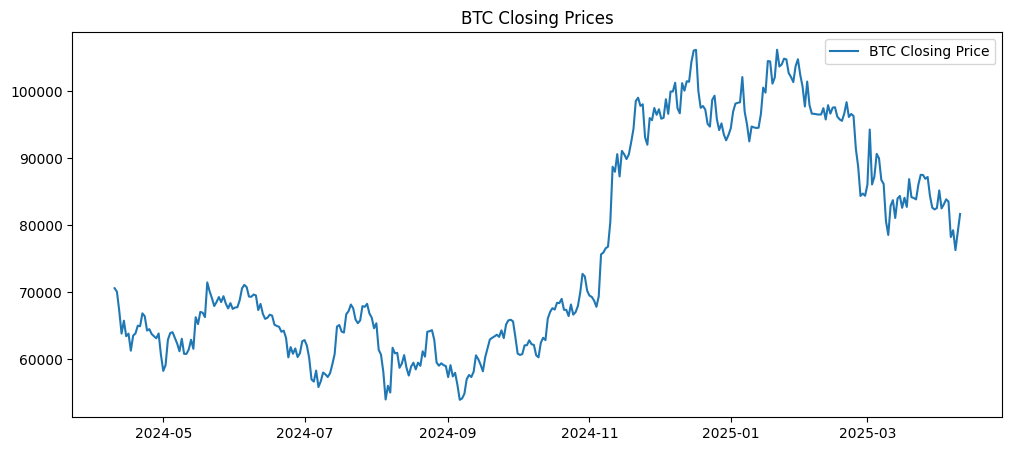

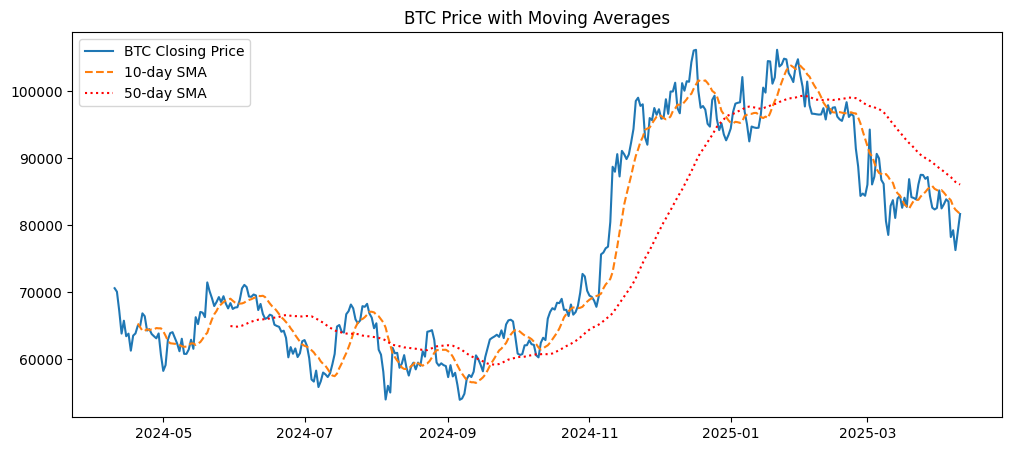

Baseline Accuracy (always hold): 0.00
Model Accuracy: 0.48


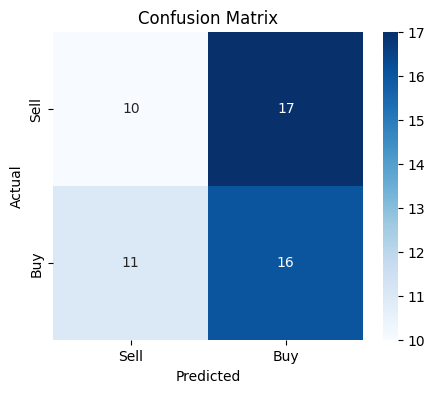

              precision    recall  f1-score   support

          -1       0.48      0.37      0.42        27
           1       0.48      0.59      0.53        27

    accuracy                           0.48        54
   macro avg       0.48      0.48      0.47        54
weighted avg       0.48      0.48      0.47        54

Label Distribution in y: Signal
 1    135
-1    131
Name: count, dtype: int64
Final Portfolio Value: $919.79


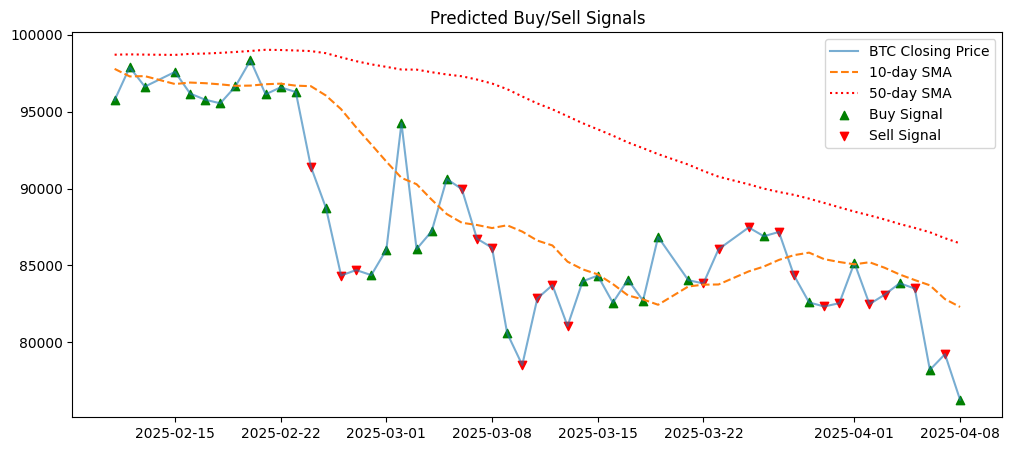

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# =====================================
# 1. Fetch and Visualize BTC Data
# =====================================
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(period="1y")

plt.figure(figsize=(12, 5))
plt.plot(btc_data.index, btc_data["Close"], label="BTC Closing Price")
plt.title("BTC Closing Prices")
plt.legend()
plt.show()

# =====================================
# 2. Add Moving Averages
# =====================================
btc_data["SMA_10"] = btc_data["Close"].rolling(window=10).mean().shift(1)
btc_data["SMA_50"] = btc_data["Close"].rolling(window=50).mean().shift(1)

# Visualize SMAs
plt.figure(figsize=(12, 5))
plt.plot(btc_data.index, btc_data["Close"], label="BTC Closing Price")
plt.plot(btc_data.index, btc_data["SMA_10"], label="10-day SMA", linestyle="dashed")
plt.plot(btc_data.index, btc_data["SMA_50"], label="50-day SMA", linestyle="dotted", color="red")
plt.title("BTC Price with Moving Averages")
plt.legend()
plt.show()

# =====================================
# 3. Generate Trading Signals
# =====================================
btc_data["Future Return"] = btc_data["Close"].pct_change().shift(-1)
btc_data["Signal"] = 0
btc_data.loc[btc_data["Future Return"] > 0.002, "Signal"] = 1
btc_data.loc[btc_data["Future Return"] < -0.002, "Signal"] = -1

# Drop rows without a clear signal
btc_data = btc_data[(btc_data["Signal"] != 0)].copy()

# =====================================
# 4. Feature Engineering
# =====================================
btc_data["Price Change"] = btc_data["Close"].pct_change()
btc_data["Volatility"] = btc_data["Close"].rolling(window=10).std().shift(1)
btc_data.dropna(inplace=True)

# =====================================
# 5. Technical Indicators
# =====================================

# 1. Relative Strength Index (RSI)
delta = btc_data["Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
btc_data["RSI"] = 100 - (100 / (1 + rs))

# 2. MACD (Moving Average Convergence Divergence) and Signal Line
ema12 = btc_data["Close"].ewm(span=12, adjust=False).mean()
ema26 = btc_data["Close"].ewm(span=26, adjust=False).mean()
btc_data["MACD"] = ema12 - ema26
btc_data["Signal Line"] = btc_data["MACD"].ewm(span=9, adjust=False).mean()

# 3. Bollinger Bands
sma20 = btc_data["Close"].rolling(window=20).mean()
std20 = btc_data["Close"].rolling(window=20).std()
btc_data["BB_upper"] = sma20 + (std20 * 2)
btc_data["BB_lower"] = sma20 - (std20 * 2)
 
# 4. Momentum
btc_data["Momentum"] = btc_data["Close"] - btc_data["Close"].shift(10)

# 5. Exponential Moving Average (EMA)
btc_data["EMA_10"] = btc_data["Close"].ewm(span=10, adjust=False).mean()

# Drop NaN values created by rolling calculations
btc_data.dropna(inplace=True) 

# Define features after all columns are added to btc_data
features = ["SMA_10", "SMA_50", "Price Change", "Volatility",
            "RSI", "MACD", "Signal Line", "BB_upper", "BB_lower",
            "Momentum", "EMA_10"]

# Ensure all required features are present in btc_data
X = btc_data[features]
y = btc_data["Signal"]



# =====================================
# 6. Split, Scale, and Train Model
# =====================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Baseline (Always Hold / Predict 0)
y_dummy = [0] * len(y_test)
baseline_accuracy = accuracy_score(y_test, y_dummy)
print(f"Baseline Accuracy (always hold): {baseline_accuracy:.2f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_scaled, y_train)

# =====================================
# 7. Evaluate Model
# =====================================
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Sell", "Buy"], yticklabels=["Sell", "Buy"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))
print("Label Distribution in y:", y.value_counts())

# =====================================
# 8. Backtest Strategy
# =====================================
btc_data_test = btc_data.iloc[-len(y_test):].copy()
btc_data_test["Predicted Signal"] = y_pred
btc_data_test["Position"] = btc_data_test["Predicted Signal"].replace({-1: 0, 0: 0, 1: 1}).shift(1)
btc_data_test["Strategy Return"] = btc_data_test["Close"].pct_change() * btc_data_test["Position"]

initial_cash = 1000
final_value = initial_cash * (1 + btc_data_test["Strategy Return"].fillna(0)).cumprod().iloc[-1]
print(f"Final Portfolio Value: ${final_value:.2f}")

# =====================================
# 9. Plot Buy/Sell Signals
# =====================================
plt.figure(figsize=(12, 5))
plt.plot(btc_data_test.index, btc_data_test["Close"], label="BTC Closing Price", alpha=0.6)
plt.plot(btc_data_test.index, btc_data_test["SMA_10"], label="10-day SMA", linestyle="dashed")
plt.plot(btc_data_test.index, btc_data_test["SMA_50"], label="50-day SMA", linestyle="dotted", color="red")

plt.scatter(btc_data_test.index[btc_data_test["Predicted Signal"] == 1], 
            btc_data_test["Close"][btc_data_test["Predicted Signal"] == 1], 
            label="Buy Signal", marker="^", color="g", alpha=1)

plt.scatter(btc_data_test.index[btc_data_test["Predicted Signal"] == -1], 
            btc_data_test["Close"][btc_data_test["Predicted Signal"] == -1], 
            label="Sell Signal", marker="v", color="r", alpha=1)

plt.title("Predicted Buy/Sell Signals")
plt.legend()
plt.show()

